In [9]:
import sys
import os 
import numpy as np
import gc
import cv2
import tensorflow as tf
import tensorflow.keras as keras 
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import time
import shutil

from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

In [10]:
ROOT_DIR = globals()['_dh'][0]
PROJECT_DIR = ROOT_DIR.parent
DATA_DIR = PROJECT_DIR / "data"
TRAIN_DIR = DATA_DIR / "train_v2"
MEDIA_DIR = PROJECT_DIR / "media"
PROCESSED_CSV_NAME = "files_data.csv"

IMG_WIDTH = 768
IMG_HEIGHT = 768
N_CHANNELS = 3
IMG_SIZE = [IMG_HEIGHT, IMG_WIDTH, N_CHANNELS]

gc.enable()
sys.path.append(str(PROJECT_DIR))

In [12]:
from utils import *

In [11]:
if not os.path.exists(MEDIA_DIR):
    os.makedirs(MEDIA_DIR)

# EDA

In [13]:
df = pd.read_csv(DATA_DIR / "train_ship_segmentations_v2.csv")
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [14]:
df.shape

(231723, 2)

In [15]:
all_files = os.listdir(DATA_DIR / "train_v2")
df["ImageId"].unique().shape[0] == len(all_files)

True

In [16]:
print(len(all_files), df["ImageId"].unique().shape[0])

192556 192556


In [17]:
not_empty = df[~df.EncodedPixels.isnull()]
not_empty.shape

(81723, 2)

In [18]:
df['not_empty'] = df.EncodedPixels.map(lambda rle: True if isinstance(rle, str) else False)

In [19]:
files_data = df.groupby('ImageId').agg({'not_empty': 'sum'}).reset_index().rename(columns={'not_empty': 'ships'})

In [20]:
files_data

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


<Axes: >

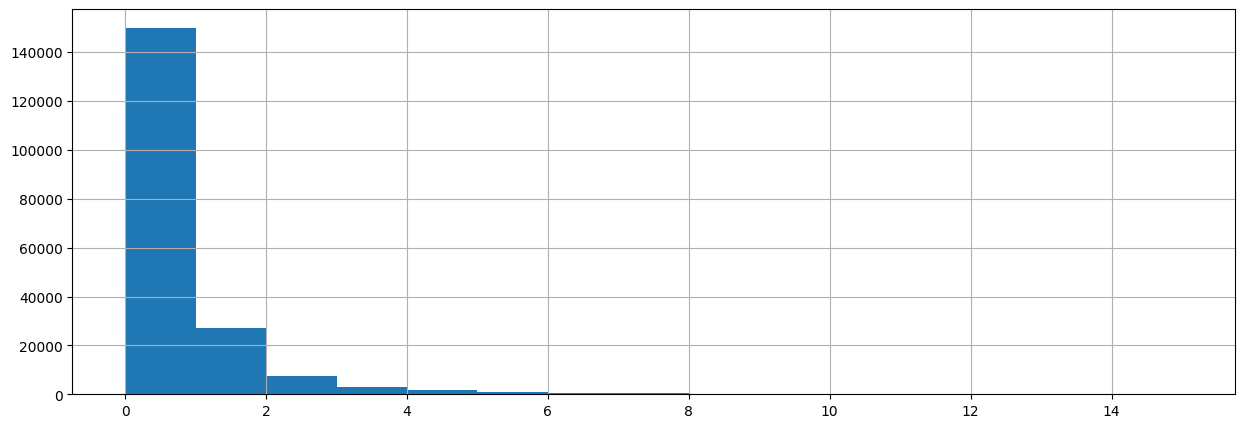

In [21]:
plt.figure(figsize=(15, 5))
files_data['ships'].hist(bins=files_data['ships'].max()) 

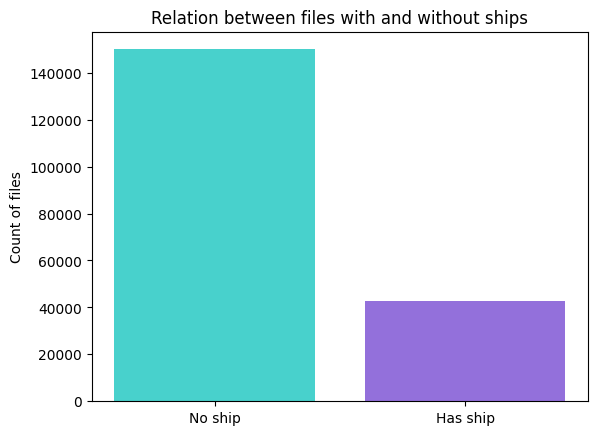

In [22]:
has_ship_hist_y = (files_data['ships'] > 0).value_counts()
has_ship_hist_x = ["No ship", "Has ship"]
plt.bar(has_ship_hist_x, has_ship_hist_y, color=['mediumturquoise', 'mediumpurple'])
plt.ylabel('Count of files')
plt.title('Relation between files with and without ships')
plt.show()

Перевіримо розподіл площ кораблів

In [23]:
# %%time

# ship_areas_ = not_empty.EncodedPixels.apply(lambda x: np.sum(rle_decode(x)))

# CPU times: total: 35 s
# Wall time: 35 s

In [24]:
ship_areas = not_empty.EncodedPixels.apply(lambda x: np.sum([int(s) for s in x.split()[1::2]]))

# CPU times: total: 1.31 s
# Wall time: 1.31 s

In [25]:
# (ship_areas_ - ship_areas).sum() # 0

In [26]:
ship_areas_min = ship_areas.min()
ship_areas_max = ship_areas.max()
ship_areas_mean = ship_areas.mean()
ship_areas_std = ship_areas.std()
ship_areas_median = ship_areas.median()
ship_areas_90th = ship_areas.quantile(0.90)

print(f"Ship areas min: {ship_areas_min}")
print(f"Ship areas max: {ship_areas_max}")
print(f"Ship areas mean: {ship_areas_mean}")
print(f"Ship areas std: {ship_areas_std}")
print(f"Ship areas median: {ship_areas_median}")
print(f"Ship areas 90th percentile: {ship_areas_90th}")

Ship areas min: 2
Ship areas max: 25904
Ship areas mean: 1567.4028486472596
Ship areas std: 2842.08120314158
Ship areas median: 408.0
Ship areas 90th percentile: 4872.0


<Axes: >

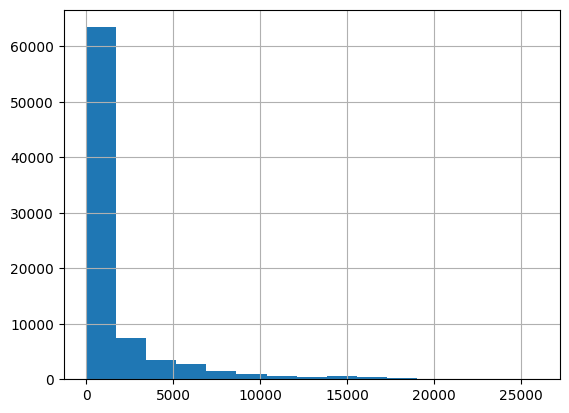

In [27]:
ship_areas.hist(bins=15)

<Axes: >

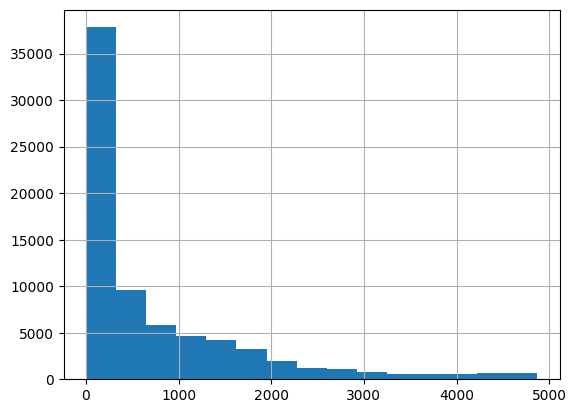

In [28]:
ship_areas[ship_areas < ship_areas_90th].hist(bins=15)

Як бачимо, малих кораблів значно більше, ніж великих. 

Якби наша зада була б вирішити змагання, а не просто побудувати UNet модель, то можна було б спрбувати побудувати окремо сегментатори для малих і великих корбалів, після чого їх об'єданти.

In [29]:
not_empty = pd.concat([not_empty, pd.Series(ship_areas, name="ship_size")], axis=1)
not_empty.sample(5)

,ImageId,EncodedPixels,ship_size
40806,2d48cbab0.jpg,690 37 1457 39 2223 42 2990 43 3757 45 4524 47...,8098
87235,6046848af.jpg,99817 1 100584 3 101351 5 102118 7 102885 9 10...,108
205361,e30778a8a.jpg,252621 16 253389 16 254157 16 254925 16 255693...,144
43581,305ea0ab0.jpg,339044 2 339811 5 340578 7 341346 6 342113 7 3...,122
187380,cf0d75e93.jpg,228125 1 228893 2 229661 2 230429 2 231197 2 2...,13


Перевіримо якість зображень

In [30]:
files_data['file_size_kb'] = files_data.ImageId.map(lambda fname: os.stat(TRAIN_DIR / fname).st_size / 1024)

<Axes: >

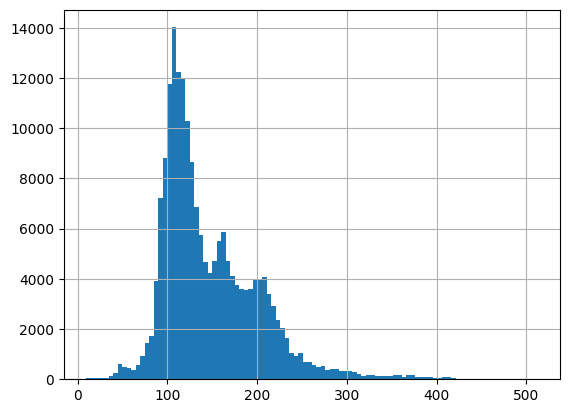

In [31]:
files_data["file_size_kb"].hist(bins=100)

In [32]:
files_data["file_size_kb"].describe()

count    192556.000000
mean        147.174686
std          54.292004
min           9.612305
25%         108.333496
50%         130.307617
75%         177.967529
max         511.942383
Name: file_size_kb, dtype: float64

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\1884615198.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


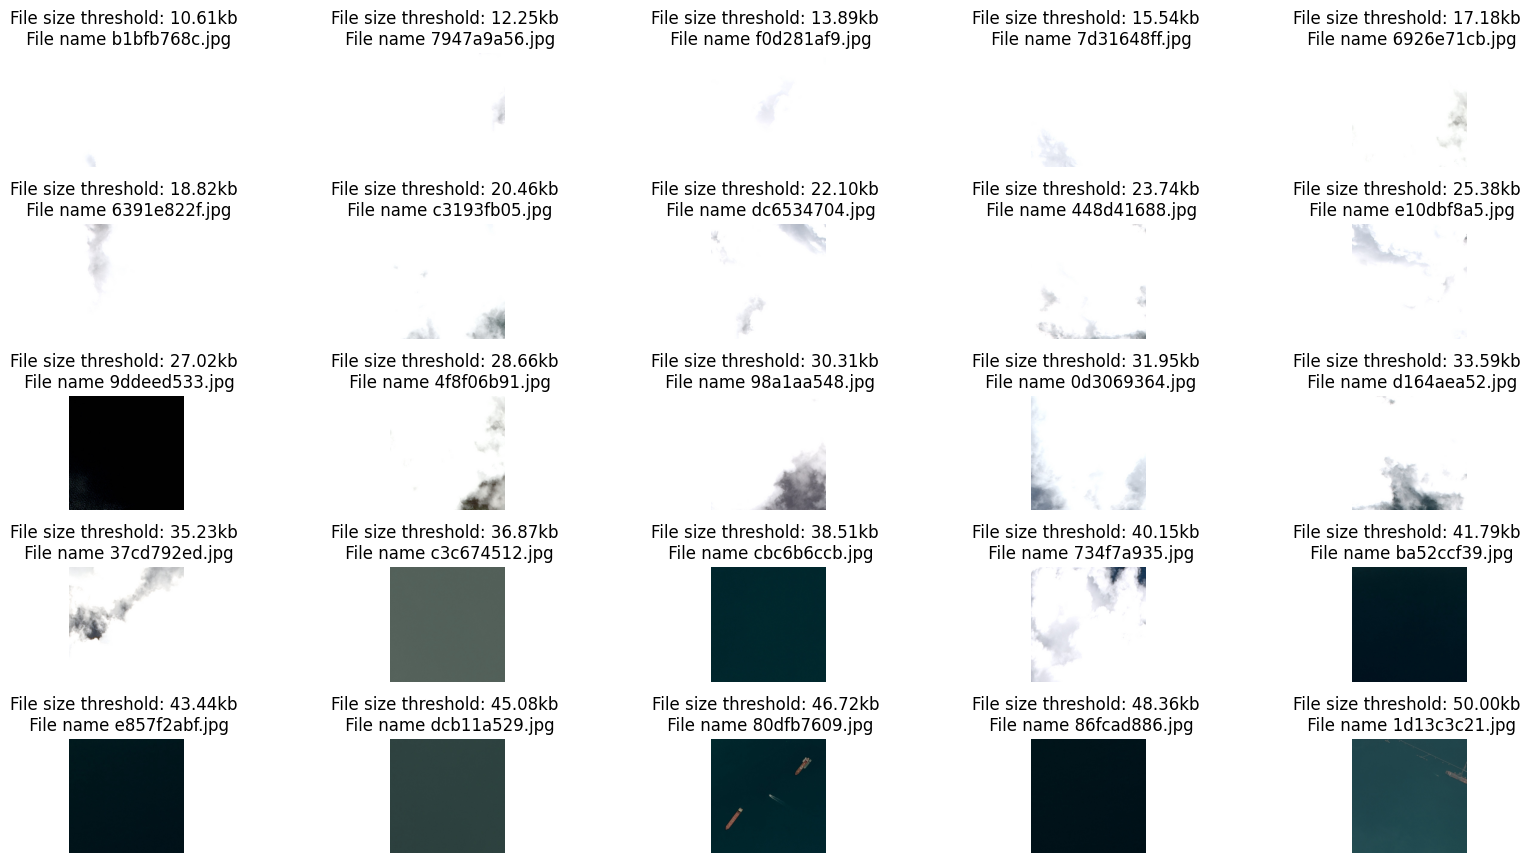

In [33]:
file_size_threshold = 50

ncols = 5
n = ncols ** 2
file_size_thresholds = np.linspace(files_data["file_size_kb"].min() + 1, 50, n)

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, file_size_threshold in enumerate(file_size_thresholds):
    try:
        fname = files_data[files_data.file_size_kb < file_size_threshold].sort_values(by="file_size_kb", ascending=False).ImageId.iloc[0]
        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.random.randn(768, 768, 3) * 255

    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"File size threshold: {file_size_threshold:.2f}kb \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

# image = imageio.imread(TRAIN_DIR / df[df.file_size_kb < file_size_threshold].sort_values(by="file_size_kb", ascending=False).ImageId.iloc[0])
# plt.imshow(image)
plt.show()

In [34]:
optimal_min_kb = 38 # discard all images with file size less than this

Продемонструю файл з ураженнями. Пропоную відшукати усі такі зображення за допомогою фільтрування по HSV. Ми можемо шукати його по відсотку пікселей такого синього кольору, або ж ще абсолютно чорного. Але оскільки такий колір не змінюється, то ми можемо знайти їх і без hsv фільтрування. Краще використовувати синій, оскільки далі зустрічаються деякі обрізані зображення, на яких присутні човни. Аналогічно можемо відфільтрувати зображення з хмарами і без. Для цього я написав додаток pickerd.py з використанням opencv, який допоможе відшукати потрібні параметри hsv. 

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\2795714712.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  corrupted_file = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")


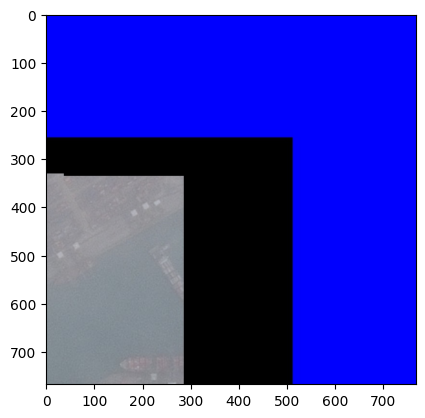

In [35]:
corrupted_file = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")
plt.imshow(corrupted_file)
plt.show()

In [36]:
corrupted_file[0, 0]

array([  0,   0, 254], dtype=uint8)

In [37]:
# df["absolute_black"] = df.ImageId.map(lambda fname: np.sum(imageio.imread(TRAIN_DIR / fname) == 0) / (768 * 768 * 3))

In [38]:
HSV_BLUE_MIN = [115, 250, 250]
HSV_BLUE_MAX = [125, 255, 255]

HSV_BLACK_MIN = [0, 0, 0]
HSV_BLACK_MAX = [2, 2, 2]

HSV_WHITE_MIN = [0, 0, 119]
HSV_WHITE_MAX = [179, 7, 255]

In [39]:
def hsv_mask(image, hsv_min, hsv_max):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, np.array(hsv_min), np.array(hsv_max))
    return mask



In [40]:
files_data[files_data.ImageId == "2f6c0deaa.jpg"]

,ImageId,ships,file_size_kb
35679,2f6c0deaa.jpg,0,35.948242


In [41]:
files_data.shape

(192556, 3)

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\1863364596.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(r"D:\Python\WINSTARS\test-task\data\train_v2\8a3606c32.jpg")


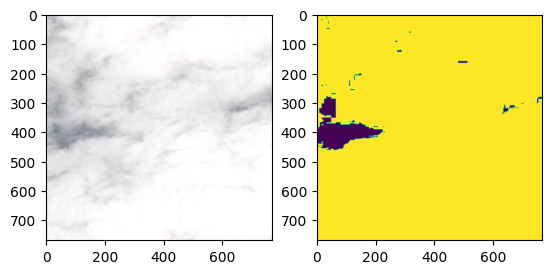

In [42]:
image = imageio.imread(r"D:\Python\WINSTARS\test-task\data\train_v2\8a3606c32.jpg")
mask = hsv_mask(image, hsv_min=HSV_WHITE_MIN, hsv_max=HSV_WHITE_MAX)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\71695037.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(r"D:\Python\WINSTARS\test-task\data\train_v2\abfc0019a.jpg")


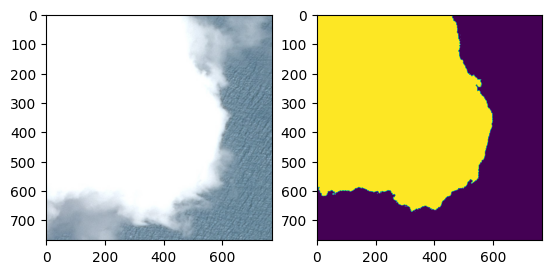

In [43]:
image = imageio.imread(r"D:\Python\WINSTARS\test-task\data\train_v2\abfc0019a.jpg")
mask = hsv_mask(image, hsv_min=HSV_WHITE_MIN, hsv_max=HSV_WHITE_MAX)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\127215267.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")


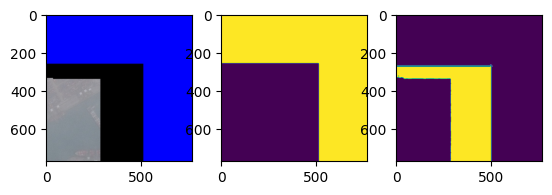

In [44]:
image = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")
mask_blue = hsv_mask(image, hsv_min=HSV_BLUE_MIN, hsv_max=HSV_BLUE_MAX)
mask_black = hsv_mask(image, hsv_min=HSV_BLACK_MIN, hsv_max=HSV_BLACK_MAX)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask_blue)
plt.subplot(1, 3, 3)
plt.imshow(mask_black)
plt.show()

In [45]:
# for OSError: image file is truncated
temp_func_errors = []

def temp_func(fname, hsv_min, hsv_max, name):
    global temp_func_errors

    try:
        image = imageio.imread(TRAIN_DIR / fname)
        mask = hsv_mask(image, hsv_min, hsv_max)
        mask = mask.astype(np.float32) / 255.
    except Exception as e:
        temp_func_errors.append((name, fname, e))
        return pd.NA

    return np.sum(mask) / (mask.shape[0] * mask.shape[1])

In [46]:

# If already runned once, load from csv
if (DATA_DIR / PROCESSED_CSV_NAME).exists():
    files_data = pd.read_csv(DATA_DIR / PROCESSED_CSV_NAME)

if "blue" not in files_data.columns:
    files_data["blue"] = files_data.ImageId.map(lambda fname: temp_func(fname, hsv_min=HSV_BLUE_MIN, hsv_max=HSV_BLUE_MAX, name="blue"))
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)

if "white" not in files_data.columns:
    files_data["white"] = files_data.ImageId.map(lambda fname: temp_func(fname, hsv_min=HSV_WHITE_MIN, hsv_max=HSV_WHITE_MAX, name="white"))
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)

if "black" not in files_data.columns:
    files_data["black"] = files_data.ImageId.map(lambda fname: temp_func(fname, hsv_min=HSV_BLACK_MIN, hsv_max=HSV_BLACK_MAX, name="black"))
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)

# TODO: add gray color

print(temp_func_errors)

# [
# ('blue', '6384c3e78.jpg', OSError('image file is truncated (51 bytes not processed)')), 
# ('white', '6384c3e78.jpg', OSError('image file is truncated (51 bytes not processed)')), 
# ('black', '6384c3e78.jpg', OSError('image file is truncated (51 bytes not processed)'))
# ]

[]


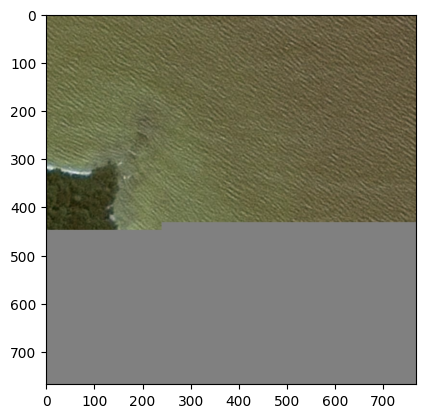

In [47]:
# image = image.imread(str(TRAIN_DIR / "6384c3e78.jpg")) # this function can't read this image
image = cv2.imread(str(TRAIN_DIR / "6384c3e78.jpg"))
plt.imshow(image)

Інший варіант - не викидати такі дані, а навпаки сприймати їх як аугментації, а також зробити моделювання таких шумів і додати його в пайплайн albumentatoins (бібліотека для агументацій). 

Третій варіант - відзверкалити зображення на чорні і блакитні області. Як бачимо, зазвичай чорні області і блакитн розташовані один біля одного. Тоді робтмо маску чорних і блакитних областей, подавляємо хибні спрацювання для чорного через Morphological Transform Opening, знаходимо границю і відзеркалюємо.

За видалення:
- Поки що це викиди, які будуть лише погіршувати результати моделі.

На користь цього варіанту можу сказати, що 
- це може покращити робастність системи, якщо таких даних достатньо 
- якщо вже до нас приходиять такі дані, то слід дізнатися наскільки це часта подія (тут все таки треба запускати алгоритм нижче і дивитися розподіл), тоді це можуть виявитися не викиди, а стандартний стан, і нам необхідно буде опрацьовувати такий випадок. 


Щодо зображень з хмарами, їх треба видаляти, оскільки вони не несуть ніякої цінності для моделі. Їх можна використовувати лише тоді, коли їх відносно не багато, скажімо, 1/4 зображення. Випадки, коли хмари закривають маже все зображення, можна опрацьовувати програмно - фільтрувати по hsv і дивитися відсоток покриття зображення хмарою.
Алгоритм може виглядати так: 
- запускати кожні n кадрів для перевірки
- якщо відсоток виріс до порогового значення, то на наступних кадрах, ймовірно, будуть одні хмари. Тоді дивимось не кожні n кадрів, а кожен кадр, поки відсоток не впаде
- коли відсоток знову впаде - знову можна передавати зображення мережі, а частоту перерівки алгоритмом зменшити до кожні n кадрів. 

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\1658964335.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_before = imageio.imread(MEDIA_DIR / "027b381f0_before.jpg")
C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\1658964335.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_after = imageio.imread(MEDIA_DIR / "027b381f0_after.png")


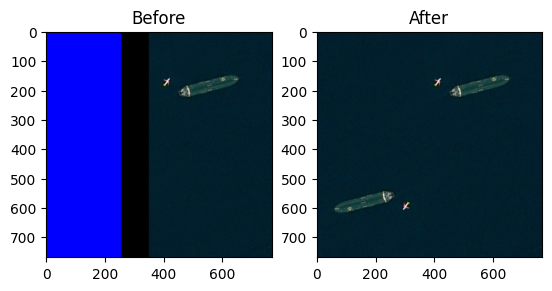

In [48]:
img_before = imageio.imread(MEDIA_DIR / "027b381f0_before.jpg")
img_after = imageio.imread(MEDIA_DIR / "027b381f0_after.png")

plt.subplot(1, 2, 1)
plt.imshow(img_before)
plt.title("Before")

plt.subplot(1, 2, 2)
plt.imshow(img_after)
plt.title("After")

plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\663257793.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


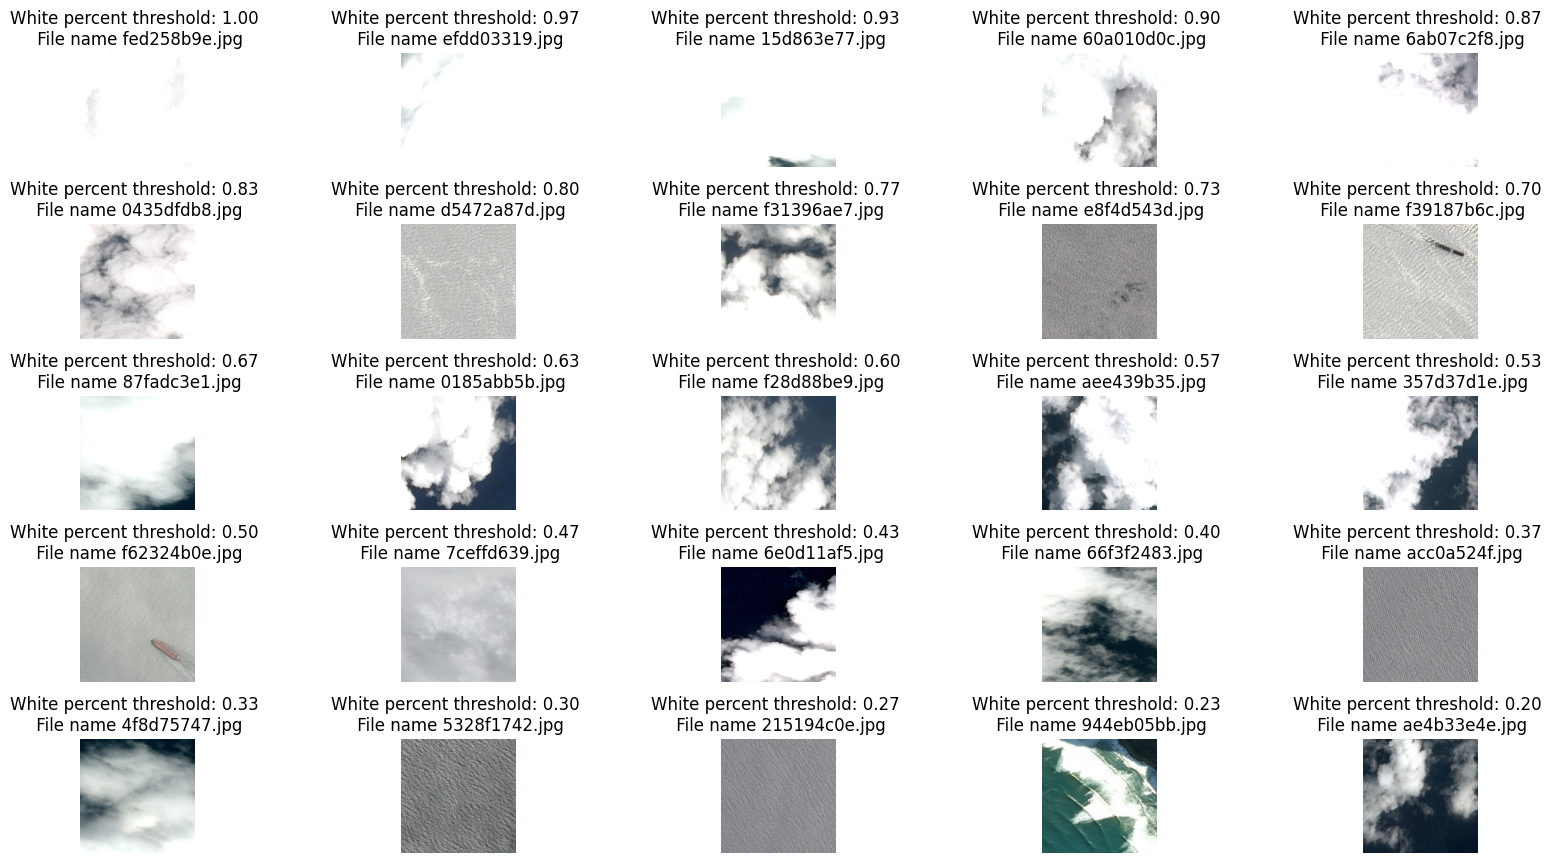

In [49]:
ncols = 5
n = ncols ** 2
white_thresholds = np.linspace(1, 0.2, n)

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, white_threshold in enumerate(white_thresholds):
    try:
        fname = files_data[files_data.white < white_threshold].sort_values(by="white", ascending=False).ImageId.iloc[0]
        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.zeros((IMG_WIDTH, IMG_HEIGHT, N_CHANNELS))
        image[0] = 255

    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"White percent threshold: {white_threshold:.2f} \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

plt.show()

На малюнку видні не тільки зображення з хмарами, а ще й з висвітленим морем. За рахунок відтінків сірого, HSV покиває їх також. Знаючи такі приклади, ми могли б більш точно підібрати параметри для фільтрування, з використанням picker_d, який би викинув відтінки сірого 

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\636987516.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


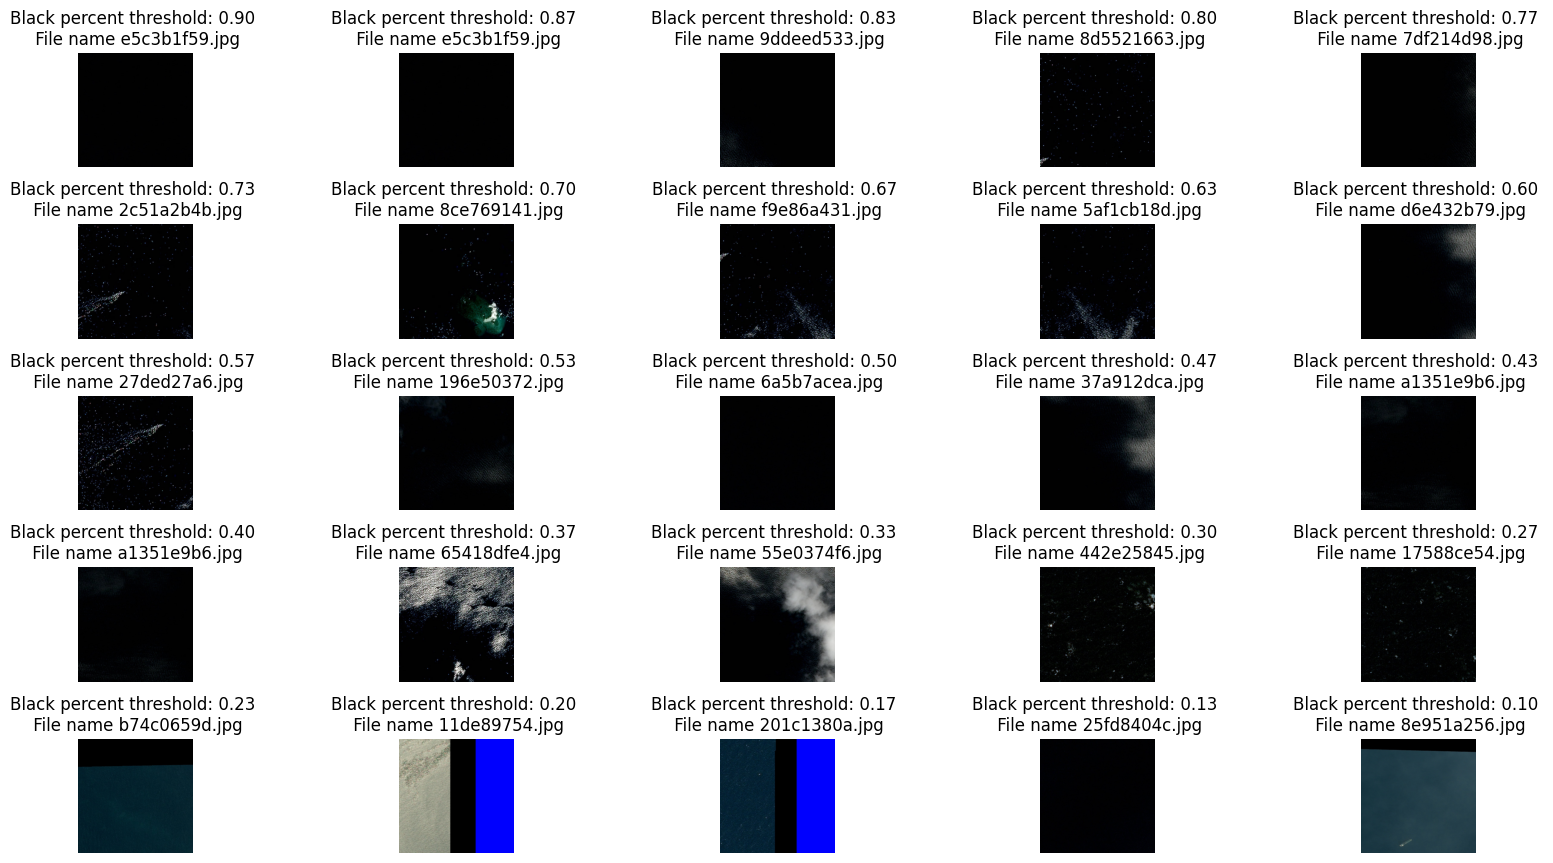

In [50]:
ncols = 5
n = ncols ** 2
black_thresholds = np.linspace(0.9, 0.1, n)

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, black_threshold in enumerate(black_thresholds):
    try:
        fname = files_data[files_data.black > black_threshold].sort_values(by="black", ascending=True).ImageId.iloc[0]
        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.random.randn(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS).astype(np.uint8) * 255


    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"Black percent threshold: {black_threshold:.2f} \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\2081491094.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


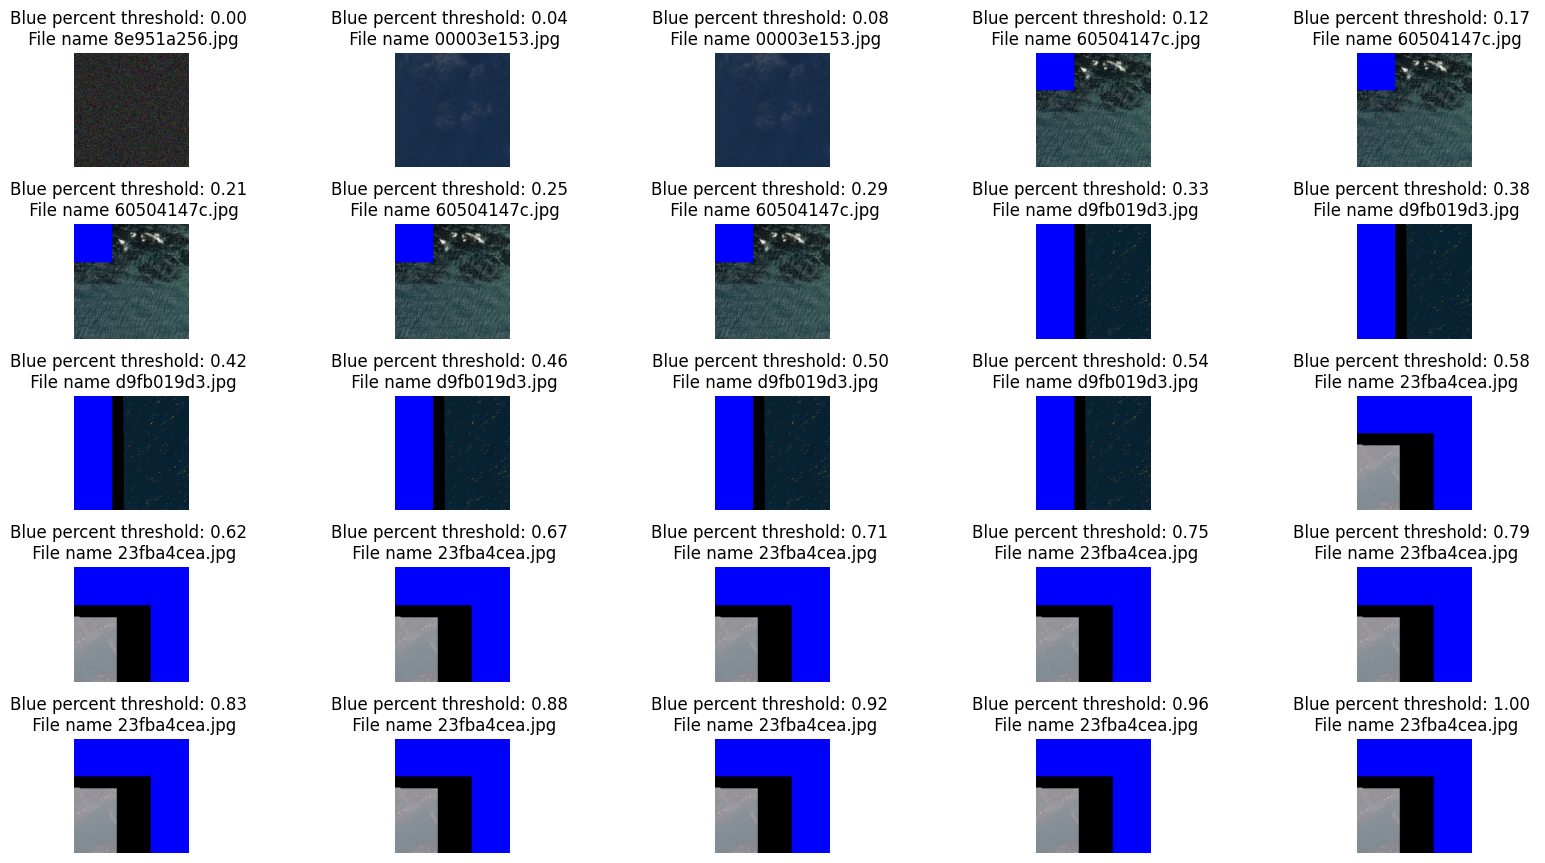

In [51]:
ncols = 5
n = ncols ** 2
blue_thresholds = np.linspace(0, 1, n)
delta = 0.05

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, blue_threshold in enumerate(blue_thresholds):
    try:
        # fname = files_data[(blue_threshold - delta < files_data.blue) & (files_data.blue < blue_threshold + delta)] \
        # .sort_values(by="blue", ascending=False) \
        # .ImageId.iloc[0]

        fname = files_data[files_data.blue < blue_threshold] \
        .sort_values(by="blue", ascending=False) \
        .ImageId.iloc[0]

        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.random.randn(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS).astype(np.uint8) * 255


    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"Blue percent threshold: {blue_threshold:.2f} \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

plt.show()

In [52]:
min_blue_threshold = 0.1

with_blue_shape = files_data[files_data.blue >= min_blue_threshold].shape
print(f"Total count of currupted with minimum level of blue={min_blue_threshold} files: {with_blue_shape[0]}")

Total count of currupted with minimum level of blue=0.1 files: 456


C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\2220641641.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(TRAIN_DIR / "03c807bd1.jpg")


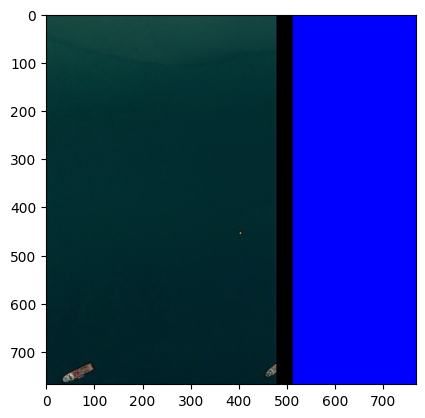

In [53]:
img = imageio.imread(TRAIN_DIR / "03c807bd1.jpg")
plt.imshow(img)   

Перевіримо, чи парвильно виконується кодування і декодування RLE

True
True


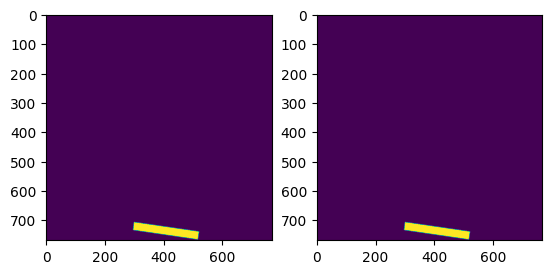

In [54]:
fname = "99d10330c.jpg"
rle = df[df.ImageId == fname].EncodedPixels.values[1]
mask = rle_decode(rle)
rle2 = rle_encode(mask)
mask2 = rle_decode(rle2)

print(rle == rle2)
print((1 - (mask - mask2)).all())

plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(mask2)
plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\3535781876.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(TRAIN_DIR / fname)


2c11daad5.jpg


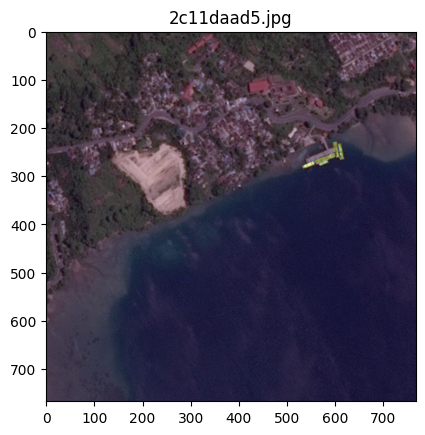

In [55]:
n = 5

fname = np.random.choice(files_data[files_data.ships == n].ImageId.values)
# fname = "99d10330c.jpg"
rles = df[df.ImageId == fname].EncodedPixels.values

img = imageio.imread(TRAIN_DIR / fname)
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
for rle in rles:
    mask_ = rle_decode(rle)
    mask = mask + mask_

mask = mask.clip(0, 1)
print(fname)
plt.imshow(img)
plt.imshow(mask, alpha=0.3)
plt.title(fname)
plt.show()

Об'єднаємо маски для виходу в одну строку rle

In [56]:
def get_mask(image_id):
    rles = df[df.ImageId == image_id].EncodedPixels.values
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    for rle in rles:
        mask += rle_decode(rle)
    
    mask = mask.clip(0, 1)
    return mask


In [57]:
if (DATA_DIR / "files_data.csv").exists():
    files_data = pd.read_csv(DATA_DIR / PROCESSED_CSV_NAME)

if "EncodedPixels" not in files_data.columns:
    print("Adding EncodedPixels column")
    files_data["EncodedPixels"] = pd.NA

    total_steps = files_data[files_data.ships > 0].shape[0]
    for index, (row_id, row) in enumerate(files_data[files_data.ships > 0].iterrows()):
        if (index + 1) % 2000 == 0:
            print(f"Processed {index + 1}/{total_steps} files")
        
        mask = get_mask(row.ImageId)
        rle = rle_encode(mask)
        files_data.loc[row_id, "EncodedPixels"] = rle
    
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)


files_data.head(10)

,ImageId,ships,file_size_kb,blue,white,black,EncodedPixels
0,00003e153.jpg,0,128.944336,0.0,0.000000,0.0,NaN
1,0001124c7.jpg,0,76.059570,0.0,0.000000,0.0,NaN
2,000155de5.jpg,1,147.625977,0.0,0.000000,0.0,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,5,75.221680,0.0,0.000000,0.0,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
4,0001b1832.jpg,0,95.627930,0.0,0.000000,0.0,NaN
5,00021ddc3.jpg,9,242.910156,0.0,0.000083,0.0,74441 7 75207 9 75972 12 76738 14 77506 10 775...
6,0002756f7.jpg,2,287.620117,0.0,0.000000,0.0,248878 1 249645 4 250413 6 251180 9 251948 10 ...
7,0002d0f32.jpg,0,125.598633,0.0,0.079178,0.0,NaN
8,000303d4d.jpg,0,205.590820,0.0,0.000380,0.0,NaN
9,00031f145.jpg,1,232.898438,0.0,0.000387,0.0,340363 1 341129 4 341896 6 342663 7 343429 10 ...


C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\3196384777.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(TRAIN_DIR / fname)


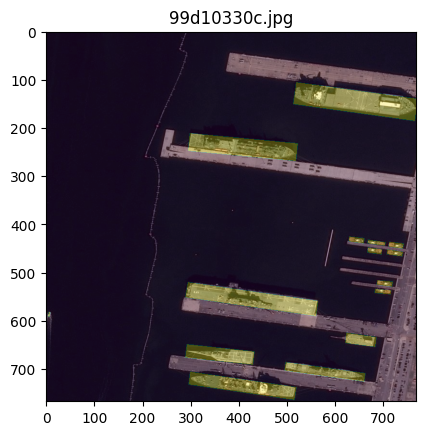

In [58]:
fname = "99d10330c.jpg"
rle = files_data[files_data.ImageId == fname].EncodedPixels.values[0]

img = imageio.imread(TRAIN_DIR / fname)
mask = rle_decode(rle)

plt.imshow(img)
plt.imshow(mask, alpha=0.3)
plt.title(fname)
plt.show()

Додамо до маски ще один клас - область малої відстані до сусідніх кораблів. Для реалізації використовую операції Eroding/Dilating. Це допоможе моделі більш точніше відрізняти один корабель від іншого, якщо вони стоять поруч. 

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\1379111364.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


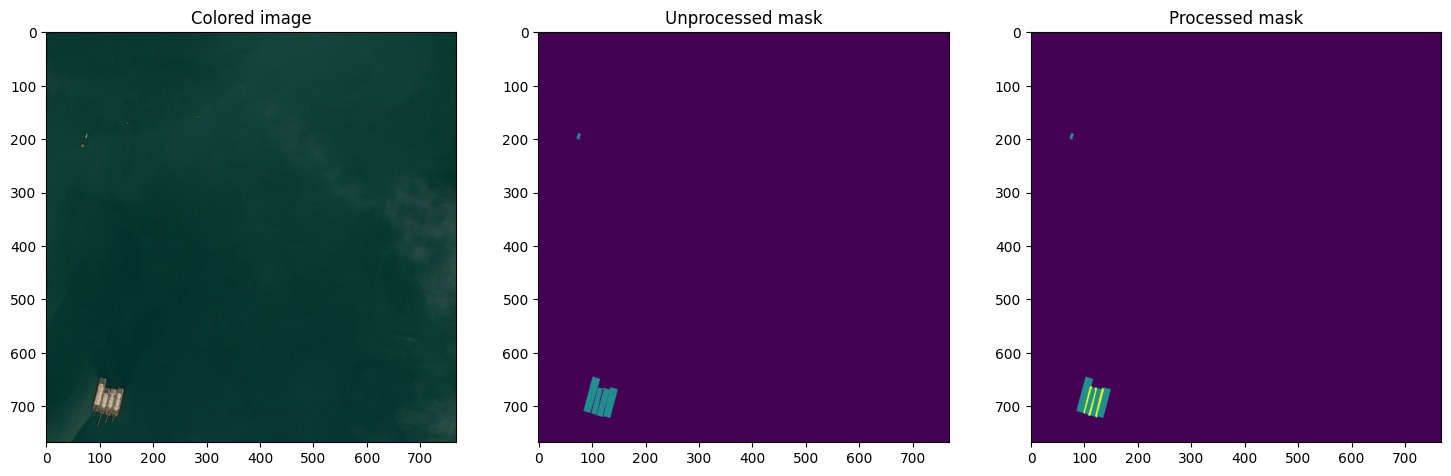

In [59]:
fname = "c8877230b.jpg"

rles = df[df.ImageId == fname].EncodedPixels.values

dilate_kernel = np.ones((5, 5),np.uint8)
erode_kernel = np.ones((2, 2),np.uint8)
iterations = 1

image = imageio.imread(TRAIN_DIR / fname)
low_distance_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
for rle in rles:
    rle_decoded_mask = rle_decode(rle)
    
    # dilating mask
    dilated_mask = cv2.dilate(rle_decoded_mask, dilate_kernel, iterations=iterations)
    low_distance_mask = low_distance_mask + dilated_mask

    # return back (closing)
    # erosion_mask = cv2.erode(mask.clip(0, 1), erode_kernel, iterations=iterations)
    # mask = cv2.bitwise_and(mask, mask, mask=erosion_mask)

    mask = mask + rle_decoded_mask

low_distance_mask = (low_distance_mask > 1) * 2

pure_mask = mask.copy()
assert pure_mask.max() == 1

mask = mask + low_distance_mask
mask = mask.clip(0, 2)

mask_visual = mask.astype(np.float32) / 2 * 255
pure_mask_visual = pure_mask * 255 / 2

plt.figure(figsize=(18, 8))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Colored image")

plt.subplot(1, 3, 2)
plt.imshow(pure_mask_visual, vmin=0, vmax=255)
plt.title("Unprocessed mask")

plt.subplot(1, 3, 3)
plt.imshow(mask_visual, vmin=0, vmax=255)
plt.title("Processed mask")

plt.show()

In [60]:
files_data_filtered = files_data[(files_data.blue < min_blue_threshold) & (files_data.file_size_kb > optimal_min_kb)]

In [61]:
files_data_filtered.shape

(191802, 7)

Оскільки в тестовому завданні просять **лише побудувати UNet**, то обмежимось лише підмножиною даних. Це дозволить зекономити багато часу на експерименти. Процес навчання побудований таким чином, що якщо потрібно буде навчати модель на всіх даних, то зміни в коді будуть мінімальні (читайте README.md). 

In [62]:
train_n = 10000
valid_n = 1000
test_n = 1000

n_files = files_data_filtered.shape[0]

train_ratio = 1 - train_n / n_files
valid_ratio = 1 - valid_n / (n_files - train_n)
test_ratio = 1 - test_n / (n_files - train_n - valid_n)

In [63]:
train_data, other_data = train_test_split(files_data_filtered, test_size=train_ratio, stratify=(files_data_filtered.ships > 0), random_state=42)
val_data, other_data = train_test_split(other_data, test_size=valid_ratio, stratify=(other_data.ships > 0), random_state=42)
test_data, other_data = train_test_split(other_data, test_size=test_ratio, stratify=(other_data.ships > 0), random_state=42)

train_fnames = train_data['ImageId'].values
val_fnames = val_data['ImageId'].values
test_fnames = test_data['ImageId'].values

In [64]:
len(train_fnames), len(val_fnames), len(test_fnames)

(10000, 1000, 1000)

In [65]:
train_data.to_csv(DATA_DIR / "train_data.csv", index=False)
val_data.to_csv(DATA_DIR / "val_data.csv", index=False)
test_data.to_csv(DATA_DIR / "test_data.csv", index=False)

Ми могли б будувати DataGenerator, який приймає ці .csv файли, але для загальності буде правильніше зробити зберігання даних у вигляді файлової структури. Користовачу не прийдеться кодувати свій датасет у RLE. Хоча окремий RLEDataGenerator ми також створимо. 

In [66]:
def make_subset(df, path_from, path_to):
    path_from = Path(path_from)
    path_to = Path(path_to)
    
    images_path = path_to / "images"
    masks_path = path_to / "masks"

    os.makedirs(images_path, exist_ok=True)
    os.makedirs(masks_path, exist_ok=True)

    for fname in df.ImageId.values:
        rle = df[df.ImageId == fname].EncodedPixels.values
        assert rle.shape[0] == 1, "More than one mask for image"
        rle = rle[0]

        fname_stem = Path(fname).stem

        if not isinstance(rle, str):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        else:
            mask = rle_decode(rle)


        assert mask.max() <= 1, f"Mask values must be in [0, 1]. Fname: {fname}"
        shutil.copy(path_from / fname, images_path / fname)

        imageio.imwrite(masks_path / (fname_stem+".png"), mask)


In [67]:
# make_subset(train_data, TRAIN_DIR, DATA_DIR / "train_subset")
# make_subset(val_data, TRAIN_DIR, DATA_DIR / "val_subset")
# make_subset(test_data, TRAIN_DIR, DATA_DIR / "test_subset")

In [68]:
# fname = "003d43308.jpg"

# mask = imageio.imread(DATA_DIR / "train_subset" / "masks" / fname)
# plt.imshow(mask)

# mask.max() # 2 => JPEG compression artifacts

В функції `make_subset` стоїть `assert mask.max() <= 1`, а клітинка вище каже, що існують піксел в масці, які більше за 1. Це значить, що jpg спотворює зображення. Треба вибрати інший формат, наприклад, png. 

C:\Users\jeka\AppData\Local\Temp\ipykernel_25504\3852501566.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(DATA_DIR / "train_subset" / "masks" / fname)


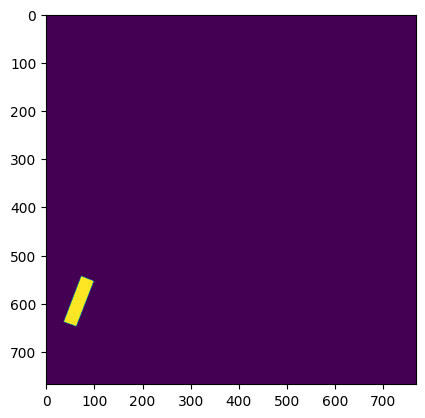

In [69]:
fname = "003d43308.png"

mask = imageio.imread(DATA_DIR / "train_subset" / "masks" / fname)
plt.imshow(mask)

In [70]:
mask.max() # 1

1

В кастомному дата генераторі нам треба буде часто зчитувати багато зображень. Давайте подивимось і порівняємо швидкість зчитування у різних бібліотек

In [71]:
image_path = TRAIN_DIR / "378562135.jpg"
image_path.exists()

True

In [72]:
def cv_safe_read(path):
    img = cv2.imread(path)
    assert img is not None, f"Can't read image from path: {path}"
    return img

In [73]:
%%timeit 
cv2.imread(str(image_path))

7.92 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
%%timeit 
cv_safe_read(str(image_path))

7.93 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
%%timeit 
imageio.imread(str(image_path))

<magic-timeit>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


6.67 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
%%timeit
Image.open(image_path)

161 µs ± 644 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [77]:
%%timeit
tf.keras.utils.load_img(image_path)

196 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
